## Convolutional Neural Networks (CNN) for Image Classification
**Dataset:** Intel Image Classification (Real-World Scenes)
**Objectives:**
- Understand and implement CNNs.
- Preprocess image data.
- Train and evaluate a CNN model.
- Visualize misclassifications and feature maps.

In [209]:
# -----------------------------
# Import necessary libraries
# -----------------------------
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [210]:
# -----------------------------
# Device Configuration
# Automatically uses GPU if available (NVIDIA CUDA or Apple MPS), otherwise falls back to CPU.
# -----------------------------
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('✅ Using NVIDIA GPU (CUDA)')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('✅ Using Mac GPU (MPS)')
else:
    device = torch.device('cpu')
    print('⚠️ Using CPU')

✅ Using Mac GPU (MPS)


#### Data Loading and Preprocessing

In [211]:
# -----------------------------
# Define directory paths for training, testing, and prediction image data.
# -----------------------------
train_dir = "../data/seg_train/seg_train"
test_dir = "../data/seg_test/seg_test"
pred_dir = "../data/seg_pred/seg_pred"

model_save_path = "../models"
os.makedirs(model_save_path, exist_ok=True)  # Ensure model save directory exists

In [212]:
# -----------------------------
# Define image transforms: resize, augment (train), normalize
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.RandomHorizontalFlip(),  # Flip images horizontally at random
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Randomly change image lighting
    transforms.ToTensor(),  # Convert PIL Image to Tensor (and standardize pixels to [0, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [213]:
# -----------------------------
# Load datasets using ImageFolder (assumes images are in subfolders by class)
# -----------------------------
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [214]:
# -----------------------------
# Split training dataset into train and validation sets
# -----------------------------
random_seed = 42
torch.manual_seed(random_seed);

val_size = int(len(train_dataset) * 0.2)
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(11228, 2806)

In [215]:
# -----------------------------
# Create data loaders
# -----------------------------
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

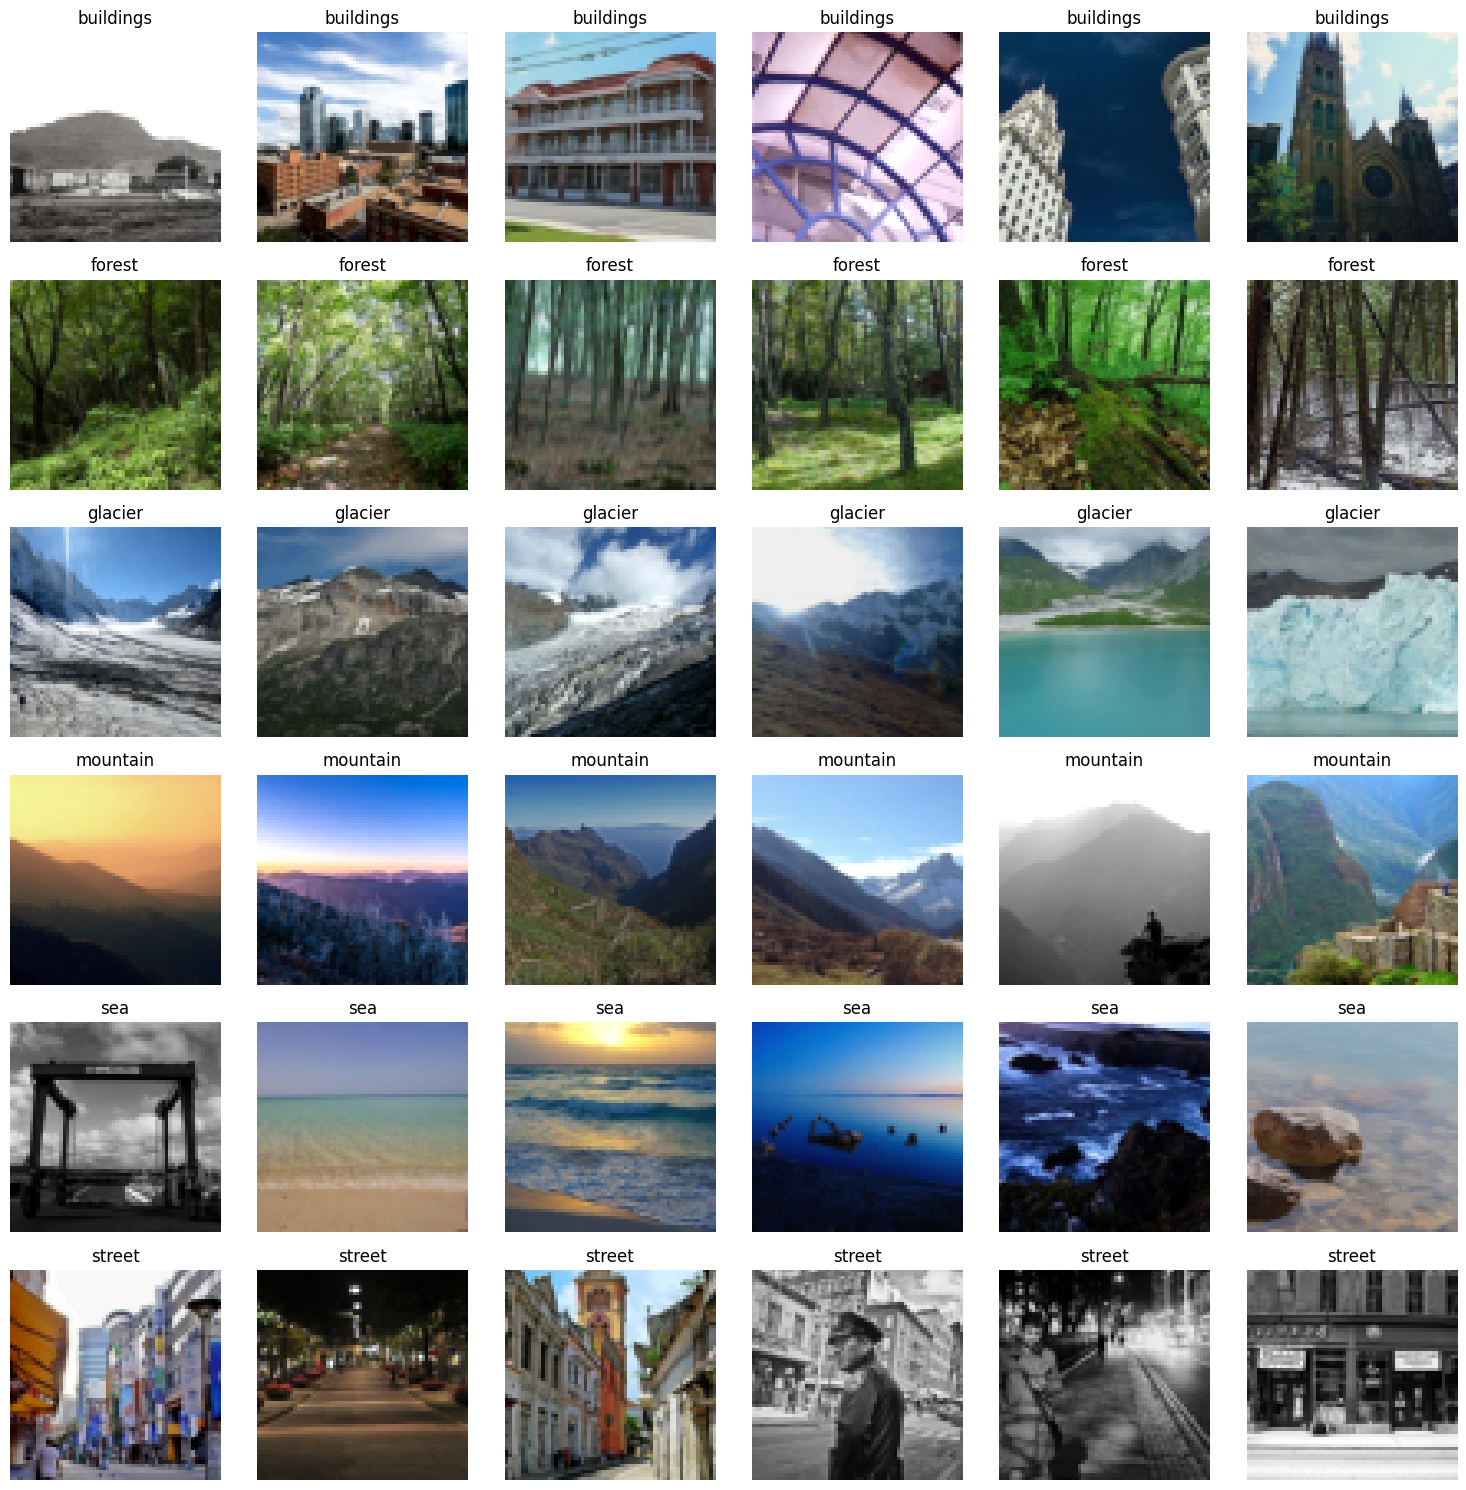

In [216]:
# -----------------------------
# Utility function to visualize samples from each class
# -----------------------------
def show_images_from_each_class(dataset, num_classes=3, images_per_class=3):
    # Get base dataset and class names
    if isinstance(dataset, torch.utils.data.Subset):
        base_dataset = dataset.dataset
        indices = dataset.indices
    else:
        base_dataset = dataset
        indices = range(len(dataset))
    
    class_indices = {v: k for k, v in base_dataset.class_to_idx.items()}
    shown = {i: 0 for i in range(num_classes)}

    plt.figure(figsize=(images_per_class * 2.5, num_classes * 2.5))
    count = 0

    for idx in indices:
        img, label = base_dataset[idx]

        if label in shown and shown[label] < images_per_class:
            count += 1
            plt.subplot(num_classes, images_per_class, count)
            img = img.permute(1, 2, 0).numpy()
            plt.imshow(img)
            plt.title(class_indices[label])
            plt.axis("off")
            shown[label] += 1

        if count >= num_classes * images_per_class:
            break

    plt.tight_layout()
    plt.show()

# Show sample images from dataset
show_images_from_each_class(train_dataset, num_classes=6, images_per_class=6)

In [217]:
# -----------------------------
# Define CNN model
# -----------------------------
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # Convolution layer
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)  # Regularization
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 512),  # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output layer
        )
# It's not necessary to use softmax activation function because we are using nnCrossEntropyLoss.
# This loss function internally applies the log-softmax operation in a numerically stable way,
# so we don’t need to apply softmax explicitly.

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

# Instantiate model
num_classes = len(train_dataset.classes)  # should be 6 for your dataset
model = CNNModel(num_classes=num_classes).to(device)

In [218]:
# -----------------------------
# Define loss, optimizer, and LR scheduler
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

In [219]:
# -----------------------------
# Training loop with validation, early stopping, and LR scheduling
# -----------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=10, early_stopping_patience=5):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0
    epochs_no_improve = 0

    for epoch in range(epochs):
        start = time.time()
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # LR Scheduler step (for ReduceLROnPlateau)
        if scheduler and isinstance(scheduler, ReduceLROnPlateau):
            current_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_acc)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr < current_lr:
                print(f"🔻 LR reduced from {current_lr:.6f} to {new_lr:.6f}")
        
        # Early stopping logic
        if val_acc >= best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_model_state = model.state_dict()
            torch.save(best_model_state, os.path.join(model_save_path, "base_cnn_model.pth"))
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
              f"Time: {time.time()-start:.2f}s")

    return train_losses, val_losses, train_accs, val_accs

In [220]:
# -----------------------------
# Plot training curves (loss and accuracy)
# -----------------------------
def plot_training(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses)+1)

    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.show()

Epoch 1/50 | Train Loss: 1.4220, Acc: 0.5467 | Val Loss: 0.8965, Acc: 0.6536 | Time: 13.89s
Epoch 2/50 | Train Loss: 0.9685, Acc: 0.6331 | Val Loss: 0.8012, Acc: 0.6900 | Time: 14.74s
Epoch 3/50 | Train Loss: 0.8781, Acc: 0.6688 | Val Loss: 0.9180, Acc: 0.6593 | Time: 14.26s
Epoch 4/50 | Train Loss: 0.8092, Acc: 0.7040 | Val Loss: 0.9186, Acc: 0.6532 | Time: 14.75s
Epoch 5/50 | Train Loss: 0.7742, Acc: 0.7186 | Val Loss: 0.6515, Acc: 0.7605 | Time: 14.49s
Epoch 6/50 | Train Loss: 0.7243, Acc: 0.7361 | Val Loss: 0.9848, Acc: 0.6878 | Time: 13.82s
Epoch 7/50 | Train Loss: 0.7087, Acc: 0.7433 | Val Loss: 0.5967, Acc: 0.7833 | Time: 13.88s
Epoch 8/50 | Train Loss: 0.6608, Acc: 0.7598 | Val Loss: 0.6435, Acc: 0.7723 | Time: 13.61s
Epoch 9/50 | Train Loss: 0.6410, Acc: 0.7713 | Val Loss: 0.6665, Acc: 0.7598 | Time: 13.72s
Epoch 10/50 | Train Loss: 0.6251, Acc: 0.7775 | Val Loss: 0.5386, Acc: 0.8061 | Time: 13.67s
Epoch 11/50 | Train Loss: 0.6114, Acc: 0.7793 | Val Loss: 0.5990, Acc: 0.7937 |

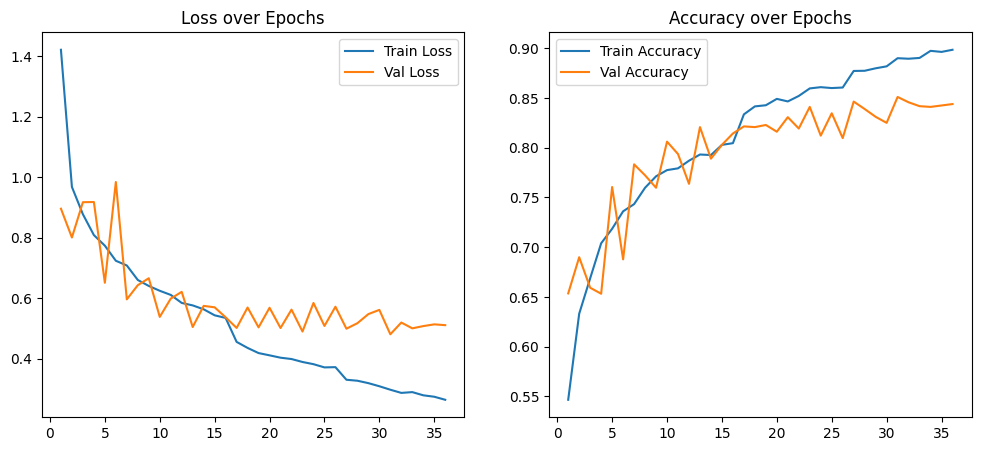

In [221]:
# Train the model
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer,
    scheduler=scheduler,
    epochs=50,
    early_stopping_patience=5
)

# Plot performance
plot_training(train_losses, val_losses, train_accs, val_accs)

📊 Classification Report:

              precision    recall  f1-score   support

   buildings     0.8255    0.8009    0.8130       437
      forest     0.9462    0.9641    0.9551       474
     glacier     0.8151    0.8210    0.8180       553
    mountain     0.7907    0.8419    0.8155       525
         sea     0.8592    0.8255    0.8420       510
      street     0.8809    0.8563    0.8684       501

    accuracy                         0.8510      3000
   macro avg     0.8529    0.8516    0.8520      3000
weighted avg     0.8515    0.8510    0.8510      3000



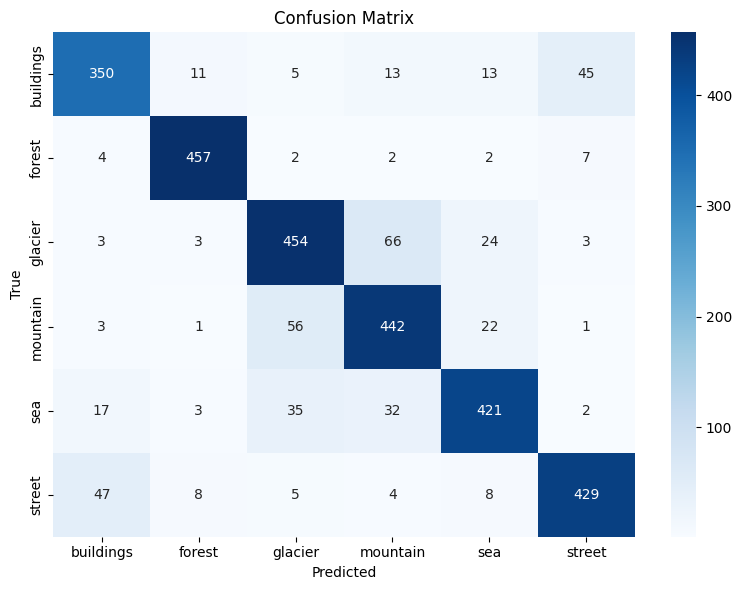

In [222]:
# -----------------------------
# Evaluate model on test data
# -----------------------------
def evaluate_model(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Classification Report
    print("📊 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Evaluate model on test dataset
class_names = test_dataset.classes
evaluate_model(model, test_loader, class_names)

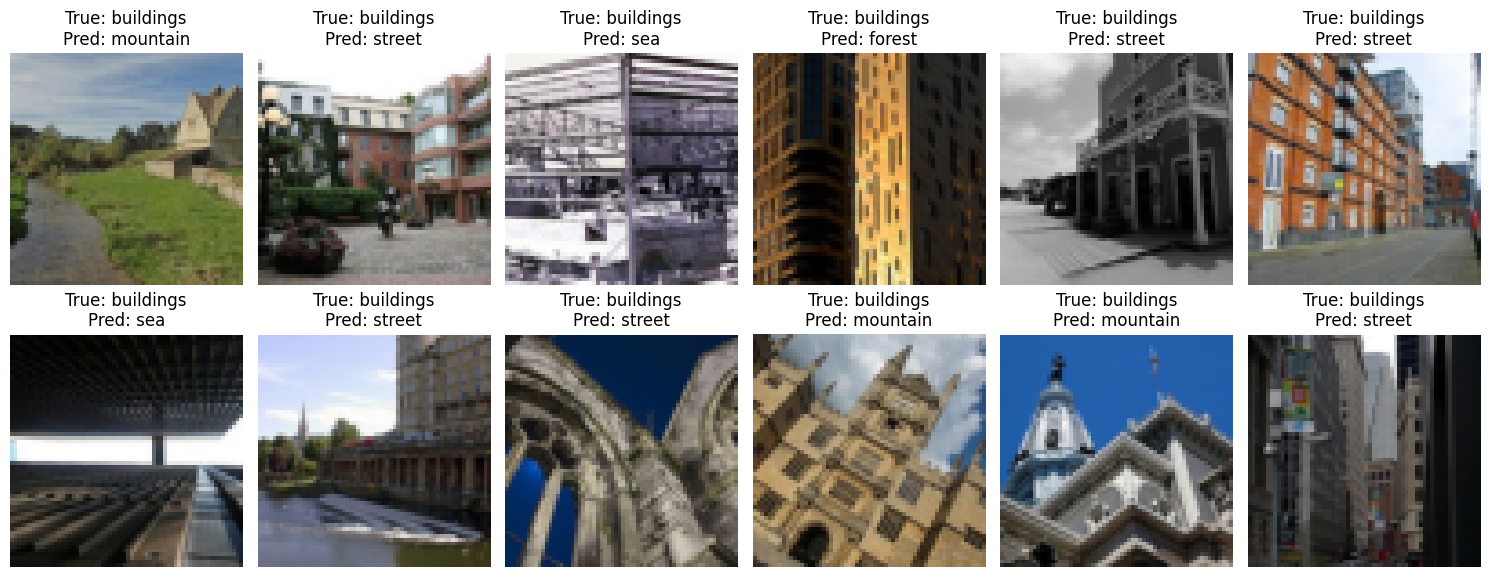

In [223]:
# -----------------------------
# Display misclassified images for visual inspection
# -----------------------------
def show_misclassified(model, loader, class_names, max_images=12):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].item(), preds[i].item()))
                    if len(misclassified) >= max_images:
                        break
            if len(misclassified) >= max_images:
                break

    plt.figure(figsize=(15, 6))
    for i, (img, true_label, pred_label) in enumerate(misclassified):
        img = img.permute(1, 2, 0).numpy()

        plt.subplot(2, max_images // 2, i+1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_misclassified(model, test_loader, train_loader.dataset.dataset.classes, max_images=12)

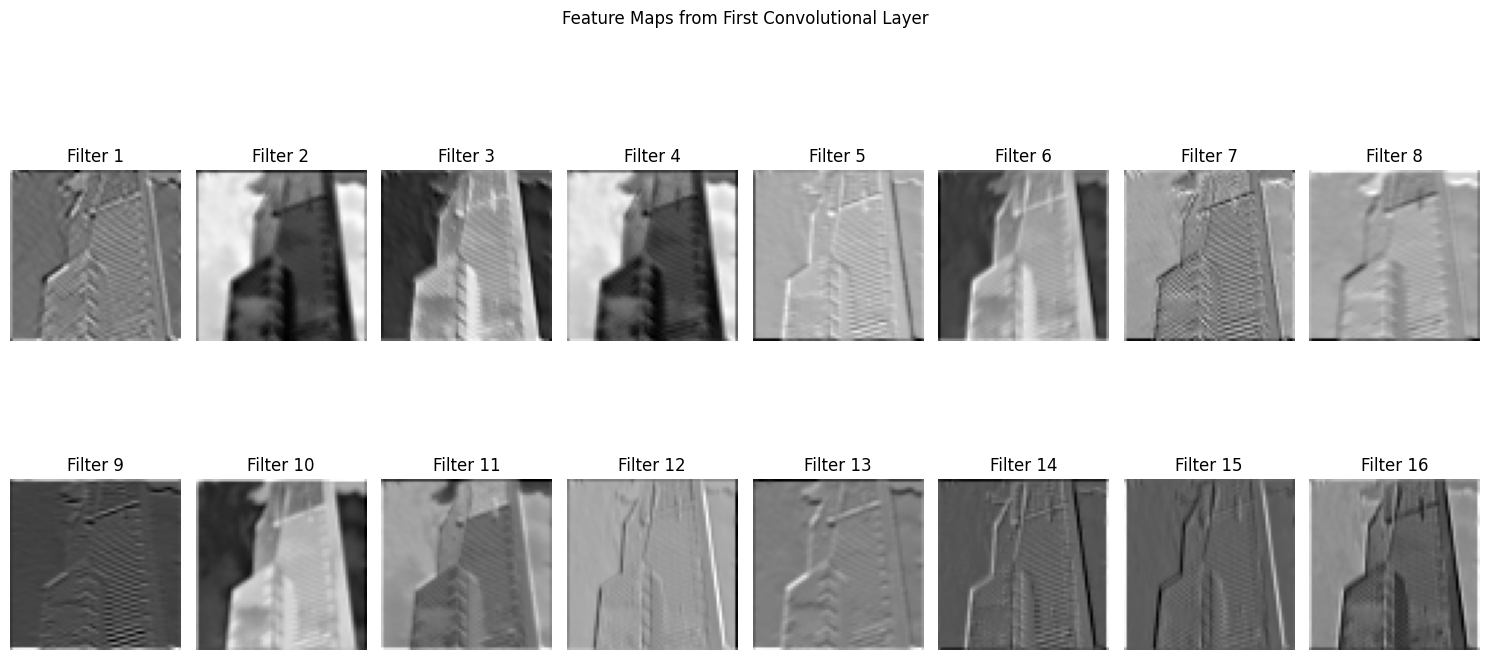

In [224]:
# -----------------------------
# Visualize feature maps from the first convolutional layer
# -----------------------------
def plot_first_layer_feature_maps(model, dataset, device, image_index=0):
    model.eval()
    img_tensor, label = dataset[image_index]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        first_conv_layer = model.conv_block[0]
        feature_maps = first_conv_layer(input_tensor)

    num_feature_maps = min(16, feature_maps.shape[1])
    plt.figure(figsize=(15, 8))
    for i in range(num_feature_maps):
        plt.subplot(2, 8, i+1)
        fmap = feature_maps[0, i].cpu().numpy()
        plt.imshow(fmap, cmap='gray')
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    plt.suptitle("Feature Maps from First Convolutional Layer")
    plt.tight_layout()
    plt.show()

# Call it!
plot_first_layer_feature_maps(model, test_dataset, device, image_index=0)

## Model Performance Evaluation
The implemented Convolutional Neural Network (CNN) was developed to classify real-world scene images from the Intel Image Classification dataset. The process included structured data loading and preprocessing, followed by model training, evaluation, and interpretability techniques.

#### Training Performance
- 	Epochs: Trained up to 35 epochs (out of 50) due to early stopping
- Best validation accuracy: ~85.10
- Training accuracy improved steadily, reaching ~89.74%
- Learning rate scheduling (via ReduceLROnPlateau) helped reduce overfitting signs by lowering LR at performance plateaus
- Train loss consistently decreased
- Validation accuracy plateaued around 84–85%
- Signs of no overfitting: validation and training accuracy had little difference

#### Test Performance
Evaluated on 3000 unseen test images:
- Overall test accuracy: 85.10%
- Best performing class: Forest
- Most confused classes: Mountain vs Glacier, Buildings vs Street, (based on confusion matrix and misclassified examples)
- There is confusion between Sea, mountain and glacier as well

#### Visual Interpretability
- Misclassified Images: Help reveal overlapping visual features between confusing classes
- Feature Maps (1st Conv Layer): Show early spatial feature extraction like edges and textures — a good sign of learning.

#### Strengths
- Stable training with validation accuracy improvements
- Effective use of learning rate scheduling and early stopping
- Strong performance in natural scenes like forest and sea

## Key Areas to Improve Model Performance:
1. Enhance Data Augmentation: The augmentation implemented is good, but we can increase variety to expose the model to more realistic distortions:
2. Stronger CNN Architecture: We can try a slightly deeper and more expressive architecture.
3. Use Pretrained CNNs: Transfer learning can be implemented to improve model performance. Finetuning pretrained models can significantly boost accuracy, especially on small/moderate datasets.
4. Regularization Tweaks: We can tweek dropouts and use weight decay in the optimizer.
5. Label Smoothing: We can add label smoothing in the loss function to improve generalization. 
6. Hyperparameter Tuning: If the system permits, we can implement Cross validation with hyperparameter tuning to improve model performance.